In [1]:
import sys

In [2]:
sys.path.append('..')

In [3]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
import arviz as az
import pymc3 as pm
from helpers import CausalModel
from copy import deepcopy
import seaborn as sns

In [4]:
%matplotlib Inline

In [5]:
%config InlineBackend.figure_format = 'svg'

In [6]:
np.set_printoptions(formatter={float: lambda x: '{:,.3f}'.format(x)})
pd.set_option('display.float_format', lambda x: '{:,.3f}'.format(x))

In [7]:
def create_standardizer_destandardizer(s: np.ndarray) -> np.ndarray:
    return lambda x: (x - s.mean()) / s.std(), lambda x: (x * s.std()) + s.mean()

## The Haunted DAG & The Causal Terror

### Code 6.1

Correlation on complete group 0.013
Correlation on selected group -0.794


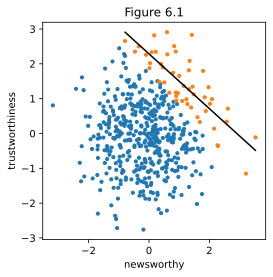

In [8]:
N = 500
p = .1

nw = np.random.normal(size=N)
tw = np.random.normal(size=N)

s = nw + tw

q = np.quantile(s, 1-p)
selected = s >= q

print(f'Correlation on complete group {np.corrcoef(tw, nw)[1, 0]:.3f}')
print(f'Correlation on selected group {np.corrcoef(tw[selected], nw[selected])[1, 0]:.3f}')

fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(nw[~selected], tw[~selected], s=10)
ax.scatter(nw[selected], tw[selected], s=10)

beta, alpha = np.polyfit(nw[selected], tw[selected], 1)
ax.plot(nw[selected], alpha + beta*nw[selected], color='black')

ax.set_title('Figure 6.1')
ax.set_xlabel('newsworthy')
ax.set_ylabel('trustworthiness')
plt.show()

### Code 6.2

In [9]:
N = 100

height = np.random.normal(10, 2, size=N)
leg_prop = np.random.uniform(.4, .5, size=N)
leg_left = leg_prop*height + np.random.normal(0, .02, size=N)
leg_right = leg_prop*height + np.random.normal(0, .02, size=N)

d = pd.DataFrame({'height': height, 'leg_left': leg_left, 'leg_right': leg_right})

In [10]:
d.head()

,height,leg_left,leg_right
0,10.136,4.645,4.647
1,7.292,3.181,3.181
2,9.533,4.465,4.416
3,6.880,3.168,3.151
4,10.417,4.470,4.507


### Code 6.3

In [11]:
with pm.Model() as model_61:
    alpha = pm.Normal('alpha', 10, 100)
    beta_left = pm.Normal('beta_left', 2, 10)
    beta_right = pm.Normal('beta_right', 2, 10)
    sigma = pm.Exponential('sigma', 1)
    mu = alpha + beta_left*d['leg_left'] + beta_right*d['leg_right']
    height = pm.Normal('height', mu, sigma, observed=d['height'])
    trace_61 = pm.sample()

<ipython-input-11-94ebdcc83d5a>:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_61 = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta_right, beta_left, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 129 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.


In [12]:
az.summary(trace_61, kind='stats', hdi_prob=.89)

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
alpha,0.898,0.335,0.386,1.465
beta_left,2.332,2.072,-1.285,5.318
beta_right,-0.324,2.070,-3.396,3.181
sigma,0.605,0.045,0.535,0.674


In [13]:
with pm.Model() as model_61b:
    pm.glm.GLM.from_formula(
        formula='height ~ leg_left + leg_right', 
        data=d,
        priors={
            'Intercept': pm.Normal.dist(10, 100),
            'Regressor': pm.Normal.dist(2, 10),
            'sd': pm.Exponential.dist(1)
        }
    )
    trace_61b = pm.sample()

<ipython-input-13-f4942e329fbc>:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_61b = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, leg_right, leg_left, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 101 seconds.
There were 327 divergences after tuning. Increase `target_accept` or reparameterize.
There were 269 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


In [14]:
az.summary(trace_61b, kind='stats', hdi_prob=.89)

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
Intercept,0.897,0.327,0.383,1.426
leg_left,3.006,2.155,-0.331,6.690
leg_right,-0.997,2.149,-4.771,2.252
sd,0.633,0.037,0.573,0.681


### Code 6.4

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


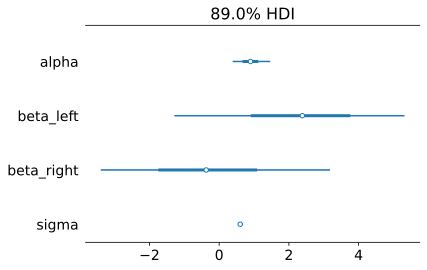

In [15]:
fig, ax = plt.subplots()
az.plot_forest(trace_61, hdi_prob=.89, combined=True, ax=ax)
plt.show()

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


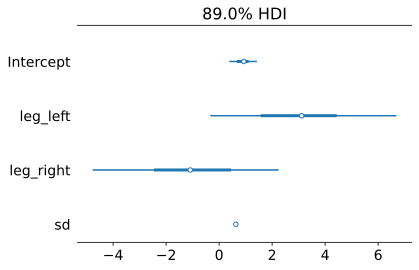

In [16]:
fig, ax = plt.subplots()
az.plot_forest(trace_61b, hdi_prob=.89, combined=True, ax=ax)
plt.show()

### Code 6.5-6.6

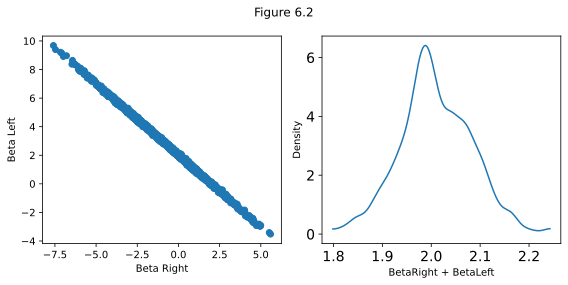

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1.scatter(trace_61b['leg_right'], trace_61b['leg_left'])
ax1.set_xlabel('Beta Right')
ax1.set_ylabel('Beta Left')

az.plot_dist(trace_61b['leg_right'] + trace_61b['leg_left'], ax=ax2)
ax2.set_xlabel('BetaRight + BetaLeft')
ax2.set_ylabel('Density')

fig.suptitle('Figure 6.2')
fig.tight_layout()
plt.show()

### Code 6.7

In [18]:
with pm.Model() as model_62:
    pm.glm.GLM.from_formula(
        formula="height ~ leg_left",
        data=d,
        priors={
            "Intercept": pm.Normal.dist(10, 100),
            "Regressor": pm.Normal.dist(2, 10),
            "sd": pm.Exponential.dist(1)
        }
    )
    
    trace_62 = pm.sample()

<ipython-input-18-2c74f23545fc>:12: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_62 = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, leg_left, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 21 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [19]:
az.summary(trace_62, hdi_prob=.89, kind='stats')

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
Intercept,0.868,0.320,0.387,1.374
leg_left,2.015,0.071,1.908,2.126
sd,0.604,0.045,0.534,0.676


### Code 6.8

In [20]:
d = pd.read_csv('../../data/milk.csv', sep=';')

std_K, dstd_K = create_standardizer_destandardizer(d['kcal.per.g'])
std_F, dstd_F = create_standardizer_destandardizer(d['perc.fat'])
std_L, dstd_L = create_standardizer_destandardizer(d['perc.lactose'])

d['K'] = std_K(d['kcal.per.g'])
d['F'] = std_F(d['perc.fat'])
d['L'] = std_L(d['perc.lactose'])

### Code 6.9

In [21]:
with pm.Model() as model_63:
    pm.glm.GLM.from_formula(
        formula='K ~ F',
        data=d,
        priors={
            'Intercept': pm.Normal.dist(0, .2),
            'Regressor': pm.Normal.dist(0, .5),
        }
    )
    
    trace_63 = pm.sample(10_000, tune=20_000)

<ipython-input-21-2725da973368>:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_63 = pm.sample(10_000, tune=20_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, F, Intercept]


Sampling 2 chains for 20_000 tune and 10_000 draw iterations (40_000 + 20_000 draws total) took 31 seconds.
The acceptance probability does not match the target. It is 0.7159176528365859, but should be close to 0.8. Try to increase the number of tuning steps.


In [22]:
with pm.Model() as model_64:
    pm.glm.GLM.from_formula(
        formula='K ~ L',
        data=d,
        priors={
            'Intercept': pm.Normal.dist(0, .2),
            'Regressor': pm.Normal.dist(0, .5),
        }
    )
    
    trace_64 = pm.sample(10_000, tune=20_000)

<ipython-input-22-a4280f310fdb>:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_64 = pm.sample(10_000, tune=20_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, L, Intercept]


Sampling 2 chains for 20_000 tune and 10_000 draw iterations (40_000 + 20_000 draws total) took 37 seconds.


In [23]:
az.summary(trace_63, kind='stats', hdi_prob=.89)

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
Intercept,-0.001,0.082,-0.132,0.130
F,0.857,0.093,0.715,1.009
sd,0.492,0.071,0.382,0.600


In [24]:
az.summary(trace_64, kind='stats', hdi_prob=.89)

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
Intercept,0.000,0.074,-0.122,0.114
L,-0.897,0.079,-1.028,-0.777
sd,0.416,0.061,0.317,0.504


### Code 6.10

In [25]:
with pm.Model() as model_65:
    pm.glm.GLM.from_formula(
        formula='K ~ L + F',
        data=d,
        priors={
            'Intercept': pm.Normal.dist(0, .2),
            'Regressor': pm.Normal.dist(0, .5),
        }
    )
    
    trace_65 = pm.sample(10_000, tune=20_000)

<ipython-input-25-a215cf171dce>:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_65 = pm.sample(10_000, tune=20_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, F, L, Intercept]


Sampling 2 chains for 20_000 tune and 10_000 draw iterations (40_000 + 20_000 draws total) took 59 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6536532433095956, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [26]:
az.summary(trace_65, kind='stats', hdi_prob=.89)

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
Intercept,-0.001,0.073,-0.114,0.117
L,-0.663,0.195,-0.974,-0.356
F,0.256,0.195,-0.046,0.577
sd,0.418,0.063,0.321,0.511


### Code 6.11

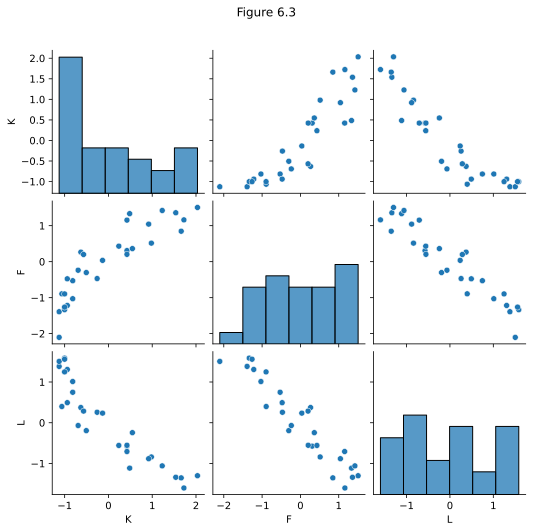

In [27]:
pp = sns.pairplot(d[['K', 'F', 'L']])
pp.fig.subplots_adjust(top=0.9)
pp.fig.suptitle('Figure 6.3')
plt.show()

### Code 6.12

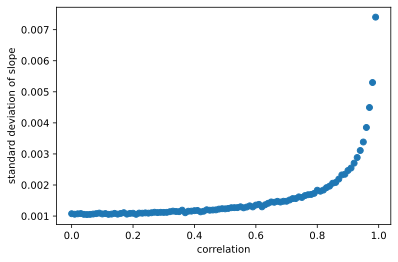

In [28]:
def mv(x, a, b, c):
    return a + x[0] * b + x[1] * c


def sim_coll(d, r=.9):
    d = d.copy()
    d['x'] = np.random.normal(
        r*d['perc.fat'],
        np.sqrt((1-r**2) * np.var(d['perc.fat']))
    )
    _, cov = curve_fit(mv, (d["perc.fat"], d['x']), d["kcal.per.g"])
    return np.sqrt(np.diag(cov))[-1]


def rep_sim_coll(d, r=0.9, n=100):
    return np.mean([sim_coll(d, r) for i in range(n)])


r_seq = np.arange(0, 1, 0.01)
stdev = list(map(lambda x: rep_sim_coll(d, x), r_seq))

plt.scatter(r_seq, stdev)
plt.xlabel("correlation")
plt.ylabel("standard deviation of slope");

### Code 6.13

In [29]:
N = 100

h0 = np.random.normal(10, 2, N)

treatment = np.repeat([0, 1], N / 2)
fungus = np.random.binomial(n=1, p=0.5 - treatment * 0.4, size=N)
h1 = h0 + np.random.normal(5 - 3 * fungus, size=N)
p = h1/h0

d = pd.DataFrame({
    "h0": h0,
    "h1": h1,
    "treatment": treatment,
    "fungus": fungus,
    "p": p,
})

d.describe()

,h0,h1,treatment,fungus,p
count,100.000,100.000,100.000,100.000,100.000
mean,9.948,13.875,0.500,0.310,1.413
std,2.049,2.618,0.503,0.465,0.204
min,4.761,6.736,0.000,0.000,1.040
25%,8.319,12.061,0.000,0.000,1.235
50%,9.849,13.874,0.500,0.000,1.407
75%,11.643,15.801,1.000,1.000,1.561
max,14.451,20.366,1.000,1.000,1.890


### Code 6.14

In [30]:
sim_p = pd.Series(np.random.lognormal(0, .25, size=1000))


In [31]:
sim_p.describe()

count   1,000.000
mean        1.049
std         0.270
min         0.431
25%         0.857
50%         1.021
75%         1.205
max         2.398
dtype: float64

<AxesSubplot:>

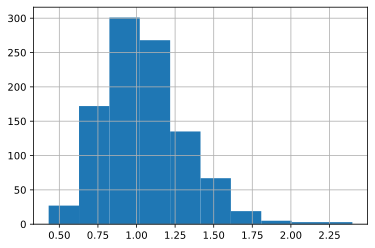

In [32]:
sim_p.hist()

### Code 6.15

In [33]:
with pm.Model() as model_66:
    p = pm.Lognormal('p', 0, .25)
    sigma = pm.Exponential('sigma', 1)
    h1 = pm.Normal('h1', p * d['h0'], sigma, observed=d['h1'])
    
    trace_66 = pm.sample(10_000, tune=10_000)

<ipython-input-33-2c9beadaf553>:6: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_66 = pm.sample(10_000, tune=10_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, p]


Sampling 2 chains for 10_000 tune and 10_000 draw iterations (20_000 + 20_000 draws total) took 26 seconds.


In [34]:
az.summary(trace_66, hdi_prob=.89, kind='stats', round_to=2)

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
p,1.380,0.020,1.340,1.410
sigma,1.960,0.140,1.740,2.180


### Code 6.16

In [35]:
with pm.Model() as model_67:
    pm.glm.GLM.from_formula(
        formula='p ~ treatment + fungus',
        data=d,
        priors={
            'Intercept': pm.Normal.dist(0, .2),
            'Regressor': pm.Normal.dist(0, .5),
        }
    )
    
    trace_67 = pm.sample(10_000, tune=20_000)

<ipython-input-35-f37851eaa5b1>:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_67 = pm.sample(10_000, tune=20_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, fungus, treatment, Intercept]


Sampling 2 chains for 20_000 tune and 10_000 draw iterations (40_000 + 20_000 draws total) took 67 seconds.


In [36]:
az.summary(trace_67, kind='stats', hdi_prob=.89, round_to=2)

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
Intercept,1.460,0.030,1.420,1.510
treatment,0.060,0.030,0.000,0.110
fungus,-0.270,0.040,-0.330,-0.220
sd,0.140,0.010,0.130,0.160


### Code 6.17

In [37]:
d['p'] = d['h1'] / d['h0']

with pm.Model() as model_68:
    pm.glm.GLM.from_formula(
        formula='p ~ treatment',
        data=d,
        priors={
            'Intercept': pm.Normal.dist(0, .2),
            'Regressor': pm.Normal.dist(0, .5),
        }
    )
    
    trace_68 = pm.sample(10_000, tune=20_000)

<ipython-input-37-4ece45c80145>:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_68 = pm.sample(10_000, tune=20_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, treatment, Intercept]


Sampling 2 chains for 20_000 tune and 10_000 draw iterations (40_000 + 20_000 draws total) took 54 seconds.


In [38]:
az.summary(trace_68, kind='stats', hdi_prob=.89, round_to=2)

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
Intercept,1.310,0.030,1.260,1.350
treatment,0.190,0.040,0.130,0.250
sd,0.190,0.010,0.170,0.210


### Code 6.18

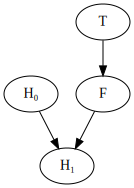

In [39]:
plant_dag = CausalModel(
    nodes=['H\N{SUBSCRIPT ZERO}', 'H\N{SUBSCRIPT ONE}', 'F', 'T'],
    edges=[
        ('H\N{SUBSCRIPT ZERO}', 'H\N{SUBSCRIPT ONE}'),
        ('F', 'H\N{SUBSCRIPT ONE}'),
        ('T', 'F'),
    ]
)

plant_dag.draw()

### Code 6.19

In [40]:
plant_dag.get_all_independence_relationships()

[('H₁', 'T', {'F'}),
 ('H₁', 'T', {'F', 'H₀'}),
 ('H₀', 'T', set()),
 ('H₀', 'T', {'F'}),
 ('H₀', 'T', {'F', 'H₁'}),
 ('H₀', 'F', set()),
 ('H₀', 'F', {'T'})]

In [41]:
plant_dag.get_implied_conditional_independencies()

[('H₁', 'T', {'F'}), ('H₀', 'T', set()), ('H₀', 'F', set())]

### Code 6.20

In [42]:
N = 1000

h0 = np.random.normal(10, 2, N)
treatment = np.repeat([0, 1], N / 2)
M = np.random.binomial(n=1, p=0.5, size=N)
fungus = np.random.binomial(n=1, p=0.5 - .4*treatment + .4*M, size=N)
h1 = h0 + np.random.normal(5 + 3*M, size=N)
p = h1/h0

d2 = pd.DataFrame({
    "h0": h0,
    "h1": h1,
    "treatment": treatment,
    "fungus": fungus,
    "p": p,
})

d2.describe()

,h0,h1,treatment,fungus,p
count,"1,000.000","1,000.000","1,000.000","1,000.000","1,000.000"
mean,10.006,16.572,0.500,0.503,1.685
std,1.977,2.670,0.500,0.500,0.248
min,3.380,9.496,0.000,0.000,1.198
25%,8.678,14.654,0.000,0.000,1.501
50%,9.922,16.540,0.500,1.000,1.657
75%,11.259,18.454,1.000,1.000,1.825
max,16.268,23.969,1.000,1.000,3.218


In [43]:
d2['p'] = d2['h1'] / d2['h0']

with pm.Model() as model_672:
    pm.glm.GLM.from_formula(
        formula='p ~ treatment + fungus',
        data=d2,
        priors={
            'Intercept': pm.Normal.dist(0, .2),
            'Regressor': pm.Normal.dist(0, .5),
        }
    )
    
    trace_672 = pm.sample(10_000, tune=20_000)

<ipython-input-43-d2f79fd5157e>:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_672 = pm.sample(10_000, tune=20_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, fungus, treatment, Intercept]


Sampling 2 chains for 20_000 tune and 10_000 draw iterations (40_000 + 20_000 draws total) took 63 seconds.


In [44]:
az.summary(trace_672, kind='stats', hdi_prob=.89, round_to=2)

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
Intercept,1.570,0.020,1.550,1.600
treatment,0.070,0.020,0.040,0.100
fungus,0.150,0.020,0.120,0.170
sd,0.240,0.010,0.230,0.250


In [45]:
d['p'] = d['h1'] / d['h0']

with pm.Model() as model_682:
    pm.glm.GLM.from_formula(
        formula='p ~ treatment',
        data=d2,
        priors={
            'Intercept': pm.Normal.dist(0, .2),
            'Regressor': pm.Normal.dist(0, .5),
        }
    )
    
    trace_682 = pm.sample(10_000, tune=20_000)

<ipython-input-45-fef7738dfef8>:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_682 = pm.sample(10_000, tune=20_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, treatment, Intercept]


ValueError: Not enough samples to build a trace.

In [ ]:
az.summary(trace_682, kind='stats', hdi_prob=.89, round_to=2)

In [ ]:
fig, ax = plt.subplots()

az.plot_forest(
    data=[trace_67, trace_672, trace_68, trace_682],
    model_names=['Fungus+Treatment', 'Fungus+Treatment (M)', 'Treatment', 'Treatment (M)'],
    combined=True,
    hdi_prob=.89,
    ax=ax,
    textsize=10,
)
ax.axvline(0, color='black')
fig.tight_layout()
plt.show()

### Code 6.21

In [ ]:
def inv_logit(x):
    return np.exp(x) / (1 + np.exp(x))


def create_pop(n):
    population = pd.DataFrame({
        'age': np.zeros(shape=n),
        'happiness': np.linspace(start=-2, stop=2, num=n),
        'married': np.zeros(shape=n, dtype='bool')
    })
    
    return population

def sim_happiness(born_on_year: int = 20, 
                  max_age: int = 65, 
                  n_years: int = 100) -> pd.DataFrame:
    
    population = create_pop(born_on_year)
    
    for _ in range(n_years):
        population['age'] += 1
        
        # Create and remove pop
        population = population[population['age'] < 65]
        population = pd.concat([population, create_pop(born_on_year)], ignore_index=True)
        
        # Marry pop
        marriable = (population['age'] > 18) & (population['married'] == False)
        marrying = np.random.binomial(n=1, p=inv_logit(population.loc[marriable, "happiness"] - 4)).astype('bool')
        population.loc[marriable, 'married'] = marrying
        
    return population

d = sim_happiness(n_years=1000)

d.describe().T

### Code 6.22

In [ ]:
d2 = d[d['age'] >= 18].reset_index(drop=True)
d2['age_norm'] = (d2['age'] - d2['age'].min()) / (d2['age'].max() - d2['age'].min())

### Code 6.23

In [ ]:
with pm.Model() as model_69:
    pm.glm.GLM.from_formula(
        formula='happiness ~ -1 + age_norm + C(married)',
        data=d2,
        priors={
            'C(married)[True]': pm.Normal.dist(0, 1),
            'C(married)[False]': pm.Normal.dist(0, 1),
            'age_norm': pm.Normal.dist(0, 2),
        }
    )
    
    trace_69 = pm.sample(10_000, tune=20_000)

az.summary(trace_69, kind='stats', hdi_prob=.89, round_to=2)

### Code 6.24

In [ ]:
with pm.Model() as model_610:
    pm.glm.GLM.from_formula(
        formula='happiness ~ -1 + age_norm',
        data=d2,
        priors={
            'age_norm': pm.Normal.dist(0, 2),
        }
    )
    
    trace_610 = pm.sample(10_000, tune=20_000)

az.summary(trace_610, kind='stats', hdi_prob=.89, round_to=2)

### Code 6.25

In [ ]:
N = 200 # Number of samples
b_GP = 1 # direct effect of Grandparents on Parents
b_GC = 0 # direct effect of Grandparents on Children
b_PC = 1 # direct effect of Parents on Children
b_U = 2 # direct effect of Unknown on Parents and Children

### Code 6.26

In [ ]:
U = 2 * stats.bernoulli(p=.5).rvs(N) - 1
G = stats.norm().rvs(N)
P = stats.norm(b_GP*G + b_U*U).rvs(N)
C = stats.norm(b_GC*G + b_U*U + b_PC*P).rvs(N)

d = pd.DataFrame({
    'U': U,
    'G': G,
    'P': P,
    'C': C,
})

d.head()

### Code 6.27

In [ ]:
with pm.Model() as model_611:
    pm.glm.GLM.from_formula(
        formula="C ~ P + G",
        data=d,
        priors={
            'Intercept': pm.Normal.dist(0, 1),
            'Regressor': pm.Normal.dist(0, 1),
        }
    )
    
    trace_611 = pm.sample(10_000, tune=20_000)
    
az.summary(trace_611, kind='stats', hdi_prob=.89)

### Code 6.28

In [ ]:
with pm.Model() as model_612:
    pm.glm.GLM.from_formula(
        formula="C ~ P + G + U",
        data=d,
        priors={
            'Intercept': pm.Normal.dist(0, 1),
            'Regressor': pm.Normal.dist(0, 1),
        }
    )
    
    trace_612 = pm.sample(10_000, tune=20_000)
    
az.summary(trace_612, kind='stats', hdi_prob=.89)